<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#import-and-define" data-toc-modified-id="import-and-define-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>import and define</a></span><ul class="toc-item"><li><span><a href="#Other-pkgs" data-toc-modified-id="Other-pkgs-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Other pkgs</a></span></li><li><span><a href="#My-own-pkgs" data-toc-modified-id="My-own-pkgs-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>My own pkgs</a></span></li><li><span><a href="#Some-fns-for-this-file-only" data-toc-modified-id="Some-fns-for-this-file-only-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Some fns for this file only</a></span></li></ul></li><li><span><a href="#Load-real-data-PSD-and-brain" data-toc-modified-id="Load-real-data-PSD-and-brain-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Load real data PSD and brain</a></span><ul class="toc-item"><li><span><a href="#PSD-and-connectome" data-toc-modified-id="PSD-and-connectome-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>PSD and connectome</a></span></li><li><span><a href="#Set-up-Parameters" data-toc-modified-id="Set-up-Parameters-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Set up Parameters</a></span></li></ul></li><li><span><a href="#Prepare-for-SBI" data-toc-modified-id="Prepare-for-SBI-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Prepare for SBI</a></span><ul class="toc-item"><li><span><a href="#Simulator" data-toc-modified-id="Simulator-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Simulator</a></span></li><li><span><a href="#Prior" data-toc-modified-id="Prior-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Prior</a></span></li><li><span><a href="#Density-estimator" data-toc-modified-id="Density-estimator-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Density estimator</a></span></li></ul></li><li><span><a href="#SBI" data-toc-modified-id="SBI-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>SBI</a></span><ul class="toc-item"><li><span><a href="#RUN" data-toc-modified-id="RUN-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>RUN</a></span></li><li><span><a href="#Get-posterior" data-toc-modified-id="Get-posterior-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Get posterior</a></span></li><li><span><a href="#PSD-estimate" data-toc-modified-id="PSD-estimate-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>PSD estimate</a></span></li></ul></li></ul></div>

This file is to try SBI_SGM when extracting features with fooof (power spectrum model)

And I train model with a general connectome.


### import and define

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('../mypkg'))
if module_path not in sys.path:
    sys.path.append(module_path)

#### Other pkgs

In [2]:
from tqdm import trange, tqdm

import torch
import torch.nn as nn 
import torch.nn.functional as F 
from sbi import utils as sutils
from sbi import analysis as analysis
from sbi.inference.base import infer
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi
from sbi.utils.get_nn_models import posterior_nn
from sklearn.preprocessing import minmax_scale

import numpy as np
import xarray as xr
from easydict import EasyDict as edict
from pathlib import Path
import pickle
import scipy

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import json
from functools import partial

import warnings
warnings.filterwarnings("ignore")

/opt/conda/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


#### My own pkgs

In [3]:
import importlib

import utils.misc
importlib.reload(utils.misc);
from utils.misc import mag2db, meg_psd2spatialfeature, save_pkl_dict2folder, load_pkl_folder2dict, get_mode

import utils.standardize
importlib.reload(utils.standardize);
from utils.standardize import stdz_psd, stdz_vec, minmax_vec, psd_2tr

import utils.brain_plot
importlib.reload(utils.brain_plot)
from utils.brain_plot import U2BrainVec, reorderU 

import sgm.sgm
importlib.reload(sgm.sgm);
from sgm.sgm import SGM


from spectrome import Brain, path, functions

import features.psm
importlib.reload(features.psm)
from features.psm import obt_psm_fs, obt_psm_raw

import constants
importlib.reload(constants)
from constants import RES_ROOT, FIG_ROOT, DAT_ROOT

import models.embedding_nets 
importlib.reload(models.embedding_nets)
from models.embedding_nets import SummaryNet

#### Some fns for this file only

In [4]:
def _remove_nopeak(theta, x):
    """The function is to remove the samples with no-peak case
        args:
            theta: the parameters, n x nparas
            x: the samples, n x dim of features
    """
    keep_idxs = np.abs(x).min(axis=1).values != 0
    #keep_idxs = x.max(axis=1).values != np.inf
    x = x[keep_idxs, :]
    theta = theta[keep_idxs, :]
    return theta, x

In [5]:
def _stdpsd_2psmfs(std_psd_DB):
    """ convert std_psd_DB to psm features
    """
    std_psd_power = 10**(std_psd_DB) # lets change it to exp scale
    psd_psm_fs = []
    for ix in range(68):
        cur_psd = std_psd_power[ix, :]
        cur_fs = obt_psm_fs(cur_psd, FREQS)
        psd_psm_fs.append(cur_fs)
    psd_psm_fs = np.concatenate(psd_psm_fs)
    return psd_psm_fs

In [6]:
def _logistic(x):
    num = np.exp(x)
    den = np.exp(x) + 1
    return num/den

### Load real data PSD and brain

#### PSD and connectome

In [7]:
# Load data
ind_psd_xr = xr.open_dataarray(DAT_ROOT/'individual_psd_reordered_matlab.nc')
ind_psd = ind_psd_xr.values
FREQS = ind_psd_xr["frequencies"].values
ind_conn_xr = xr.open_dataarray(DAT_ROOT/'individual_connectomes_reordered.nc')
ind_conn = ind_conn_xr.values

#### Set up Parameters

In [8]:
# some constant parameters for this file
paras = edict()
#v_lower = 3.5-1.8
#v_upper = 3.5+1.8
#bnds = ((5.0,30.0), (5.0,200.0), (0.1,1.0), (v_lower,v_upper), (0.5,10.0), (0.5,10.0), (5.0,30.0))
#This is the order for the above bounds:  tau_e, tau_i, alpha, speed, gei, gii, tauC,

# taue, taui, tauC, speed, alpha, gii, gei
paras.par_low = np.asarray([0.005,0.005,0.005,1.7,0.1,0.5,0.5])
paras.par_high = np.asarray([0.03, 0.20, 0.03,5.3,  1, 10, 10])
paras.plotLimits = np.array([paras.par_low, paras.par_high]).T
paras.names = ["Taue", "Taui", "TauC", "Speed", "alpha", "gii", "gei"]

paras.noise_sd = 0.15
paras.num_prior_sps = int(1e5)
paras.den_est = "nsf"
paras.is_embed = True

In [9]:
# paras  for this file
_paras = edict()
_folder_path = f"./fooofgeneralNoise_{paras.num_prior_sps:.0f}" +\
               f"_sd{paras.noise_sd*100:.0f}" +\
               f"_denest{paras.den_est}" +\
               f"_embed{paras.is_embed}"
_paras.folder_path = RES_ROOT/_folder_path
print(f"folder is {_paras.folder_path}")
print(_paras.folder_path.exists())

folder is /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/fooofgeneralNoise_100000_sd15_denestnsf_embedTrue
True


In [21]:
cur_res = edict()

### Prepare for SBI

#### Simulator

In [22]:
def simulator(params, noise_sd, sgmmodel):
    """The function to simulate samples
    """
    psd, spatialFs = sgmmodel.run_local_coupling_forward(params)
    std_spatial = stdz_vec(spatialFs.sum(axis=1)) # std it
    
    std_psd_DB = psd_2tr(psd)
    noise1 =  np.random.randn(*std_psd_DB.shape)*noise_sd 
    std_psd_DB_noise = std_psd_DB + noise1
    psd_psm_fs = _stdpsd_2psmfs(std_psd_DB_noise) # psd psm fs, two peaks
    psd_mean_fs = stdz_vec(std_psd_DB_noise.mean(axis=0)) # mean PSD, 40 dim
    
    noise2 =  np.random.randn(*std_spatial.shape)*noise_sd 
    res = np.concatenate([psd_psm_fs, psd_mean_fs, std_spatial+noise2]) 
    return res

#### Prior 

In [23]:
prior = sutils.BoxUniform(low=torch.as_tensor(paras.par_low), high=torch.as_tensor(paras.par_high))

#### Density estimator

In [24]:
if paras.is_embed:
    embedding_net = SummaryNet(num_in_fs=516)
    paras.den_est = sutils.posterior_nn(
    model=paras.den_est, embedding_net=embedding_net)
    for ix in embedding_net.parameters():
        print(ix.sum(), ix.shape)

### SBI

In [25]:
# obtain the brain
brain = Brain.Brain()
brain.add_connectome(DAT_ROOT)
brain.reorder_connectome(brain.connectome, brain.distance_matrix)
brain.bi_symmetric_c()
brain.reduce_extreme_dir()
sgmmodel = SGM(brain.reducedConnectome, brain.distance_matrix, FREQS)

simulator_sp = partial(simulator,  noise_sd=paras.noise_sd, sgmmodel=sgmmodel)
# make a SBI-wrapper on the simulator object for compatibility
simulator_wrapper, prior = prepare_for_sbi(simulator_sp, prior)

#### RUN

In [26]:
theta, x = simulate_for_sbi(simulator_wrapper, prior, 
                            num_simulations=int(paras.num_prior_sps), 
                            num_workers=50)
theta, x = _remove_nopeak(theta, x) # remove some samples
#theta, x = cur_res.theta, cur_res.x
inference = SNPE(prior=prior, density_estimator=paras.den_est)
density_estimator = inference.append_simulations(theta, x).train()
posterior = inference.build_posterior(density_estimator)


Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

/opt/conda/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt

/opt/conda/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt

 Neural network successfully converged after 44 epochs.

In [27]:
cur_res.theta = theta
cur_res.x = x
cur_res.posterior = posterior
if paras.is_embed:
    cur_res.embedding_net = embedding_net
    for ix in embedding_net.parameters():
        print(ix.sum(), ix.shape)
save_pkl_dict2folder(_paras.folder_path, cur_res, True)

/data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/fooofgeneralNoise_1000_sd5_denestnsf_embedFalse
Create a folder /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/fooofgeneralNoise_1000_sd5_denestnsf_embedFalse
Save to /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/fooofgeneralNoise_1000_sd5_denestnsf_embedFalse/theta.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/fooofgeneralNoise_1000_sd5_denestnsf_embedFalse/x.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/fooofgeneralNoise_1000_sd5_denestnsf_embedFalse/posterior.pkl


#### Get posterior

In [11]:
cur_res = load_pkl_folder2dict(_paras.folder_path)

Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/fooofgeneralNoise_100000_sd15_denestnsf_embedTrue/theta.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/fooofgeneralNoise_100000_sd15_denestnsf_embedTrue/x.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/fooofgeneralNoise_100000_sd15_denestnsf_embedTrue/posterior.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/fooofgeneralNoise_100000_sd15_denestnsf_embedTrue/embedding_net.pkl


In [12]:
post_spss = []
for ix in range(ind_psd.shape[-1]):
    curC = ind_conn[:, :, ix]
    curBrain = Brain.Brain()
    curBrain.add_connectome(DAT_ROOT) # grabs distance matrix
    # re-ordering for DK atlas and normalizing the connectomes:
    curBrain.reorder_connectome(curBrain.connectome, curBrain.distance_matrix)
    curBrain.connectome = curC# re-assign connectome to individual connectome
    curBrain.bi_symmetric_c()
    curBrain.reduce_extreme_dir()
        
    sp, raw_sps = meg_psd2spatialfeature(curBrain.reducedConnectome, ind_psd[:, :, ix], FREQS, band="alpha")
    
    std_spv = stdz_vec(raw_sps.sum(axis=1))
    std_psd_DB = psd_2tr(ind_psd[:, :, ix])
    psm_fs = _stdpsd_2psmfs(std_psd_DB)
    psd_mean_fs = stdz_vec(std_psd_DB.mean(axis=0)) # mean PSD, 40 dim
    
    #curX_raw = np.concatenate([stdz_psm_fs(psm_fs), std_spv])
    curX_raw = np.concatenate([psm_fs, psd_mean_fs, std_spv])
    curX = torch.Tensor(curX_raw)
    print(ix)
    if ix > -1:
        post_sps = cur_res.posterior.sample((10000, ), x=curX, max_sampling_batch_size=100000)
    post_spss.append(post_sps)
        

0


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

1


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

2


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

3


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

4


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

5


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

6


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

7


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

8


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

9


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

10


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

11


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

12


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

13


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

14


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

15


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

16


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

17


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

18


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

19


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

20


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

21


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

22


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

23


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

24


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

25


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

26


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

27


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

28


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

29


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

30


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

31


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

32


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

33


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

34


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

35


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

In [13]:
cur_res.post_spss = post_spss
save_pkl_dict2folder(_paras.folder_path, cur_res, True)

Save to /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/fooofgeneralNoise_100000_sd15_denestnsf_embedTrue/theta.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/fooofgeneralNoise_100000_sd15_denestnsf_embedTrue/x.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/fooofgeneralNoise_100000_sd15_denestnsf_embedTrue/posterior.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/fooofgeneralNoise_100000_sd15_denestnsf_embedTrue/embedding_net.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/fooofgeneralNoise_100000_sd15_denestnsf_embedTrue/post_spss.pkl


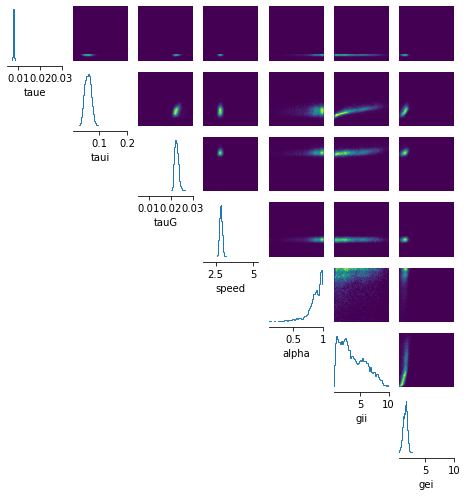

In [25]:
# taue, taui, tauC, speed, alpha, gii, gei
_ = analysis.pairplot(post_spss[29], 
                      limits=paras.plotLimits, 
                      labels=['taue','taui','tauG','speed','alpha','gii','gei'], 
                      figsize=(8,8))

#### PSD estimate

In [15]:
cur_res = load_pkl_folder2dict(_paras.folder_path)

Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/fooofgeneralNoise_100000_sd15_denestnsf_embedTrue/theta.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/fooofgeneralNoise_100000_sd15_denestnsf_embedTrue/x.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/fooofgeneralNoise_100000_sd15_denestnsf_embedTrue/posterior.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/fooofgeneralNoise_100000_sd15_denestnsf_embedTrue/embedding_net.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/fooofgeneralNoise_100000_sd15_denestnsf_embedTrue/post_spss.pkl


In [16]:
# the estimated PSD and spatial feature from SGM  
cur_est_parass = np.array([np.median(ps.numpy(), axis=0) for ps in cur_res.post_spss])
#cur_est_parass = np.array([[get_mode(ps.numpy()[:, ix]) for ix in range(7)] for ps in cur_res.post_spss])
std_psd_DB = []
raw_sp = []
for ix in trange(36):
    cur_est_paras = cur_est_parass[ix, :]
    
    cur_conn = ind_conn[:, :, ix]
    cur_brain = Brain.Brain()
    cur_brain.add_connectome(DAT_ROOT) # grabs distance matrix
    cur_brain.reorder_connectome(cur_brain.connectome, cur_brain.distance_matrix)
    cur_brain.connectome = cur_conn# re-assign connectome to individual connectome
    cur_brain.bi_symmetric_c()
    cur_brain.reduce_extreme_dir()
    
    cur_SGM_model = SGM(cur_brain.reducedConnectome, cur_brain.distance_matrix, FREQS)
    cur_psd, cur_sp = cur_SGM_model.run_local_coupling_forward(cur_est_paras)
    cur_psd = cur_psd[:68, :]
    cur_psd_DB = psd_2tr(cur_psd)
    
    std_psd_DB.append(cur_psd_DB)
    raw_sp.append(cur_sp.sum(axis=1))
    

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [00:42<00:00,  1.19s/it]


In [17]:
sgm_psd_curve = np.array(std_psd_DB).mean(axis=1).mean(axis=0)
meg_psd_curve = np.mean([psd_2tr(ind_psd[:, :, ix]).mean(axis=0) for ix in range(36)], axis=0)
cor = scipy.stats.pearsonr(stdz_vec(meg_psd_curve), stdz_vec(sgm_psd_curve))[0]
print(f"Corr is {cor:.3f}")

Corr is 0.968


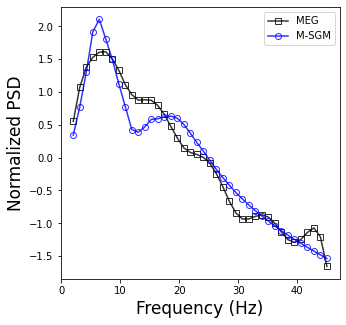

In [18]:
plt.figure(figsize=[5, 5])
plt.plot(FREQS, stdz_vec(meg_psd_curve), linestyle = '-',
         marker = 's',fillstyle = 'none',color = 'k', label = "MEG", alpha = 0.8)
plt.plot(FREQS, stdz_vec(sgm_psd_curve), linestyle = '-',
         marker = 'o',fillstyle = 'none',color = 'b', label = "M-SGM", alpha = 0.8)
plt.xlabel('Frequency (Hz)', fontsize = 17)
plt.ylabel('Normalized PSD', fontsize = 17)
plt.legend()

In [19]:
# Corrs for PSD and spatial features for each subject
meg_psd_roi_sub = np.array([psd_2tr(ind_psd[:, :, ix]) for ix in range(36)])
sgm_psd_roi_sub = np.array(std_psd_DB)

corrs_roi_sub = []
for ix in range(meg_psd_roi_sub.shape[0]):
    cur_meg = meg_psd_roi_sub[ix]
    cur_sgm = sgm_psd_roi_sub[ix]
    corrs_roi_sub.append(np.mean([scipy.stats.pearsonr(cur_meg[iy], cur_sgm[iy])[0] for iy in range(68)]))
corrs_roi_sub = np.array(corrs_roi_sub)

In [20]:
np.sort(corrs_roi_sub)

array([0.68814764, 0.73686463, 0.74212168, 0.74499916, 0.75254162,
       0.76362697, 0.76710095, 0.78135154, 0.78581641, 0.79033307,
       0.80038473, 0.80230028, 0.80345513, 0.82125736, 0.82538157,
       0.83030247, 0.83096648, 0.83549837, 0.83936233, 0.83988098,
       0.84562631, 0.84576851, 0.85300604, 0.86116998, 0.87090283,
       0.87165413, 0.87366214, 0.87699032, 0.88444706, 0.88685862,
       0.8906038 , 0.89171634, 0.89564123, 0.90236279, 0.90981379,
       0.9239296 ])

In [21]:
np.mean(corrs_roi_sub)

0.8296068574092718

In [22]:
np.argsort(corrs_roi_sub)

array([32,  2, 24,  4, 21, 31, 25, 12,  3, 16, 22,  5,  0, 18,  7, 11,  8,
       23, 15,  9, 10, 14, 34, 26,  1, 28, 13, 17, 27, 35, 19, 33,  6, 30,
       20, 29])

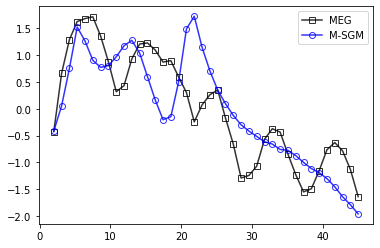

In [23]:
sub_ix = 24
roi_ix = 0
cur_sgm.shape
plt.plot(FREQS, stdz_vec(meg_psd_roi_sub[sub_ix, roi_ix, :]), linestyle = '-',
         marker = 's',fillstyle = 'none',color = 'k', label = "MEG", alpha = 0.8)
plt.plot(FREQS, stdz_vec(sgm_psd_roi_sub[sub_ix, roi_ix, :]), linestyle = '-',
         marker = 'o',fillstyle = 'none',color = 'b', label = "M-SGM", alpha = 0.8)
plt.legend()

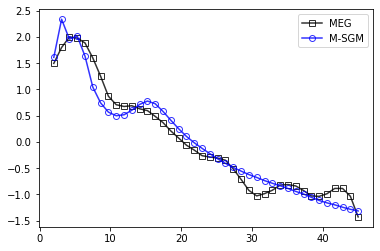

In [24]:
sub_ix = 29
cur_sgm.shape
plt.plot(FREQS, stdz_vec(meg_psd_roi_sub[sub_ix, :, :].mean(axis=0)), linestyle = '-',
         marker = 's',fillstyle = 'none',color = 'k', label = "MEG", alpha = 0.8)
plt.plot(FREQS, stdz_vec(sgm_psd_roi_sub[sub_ix, :, :].mean(axis=0)), linestyle = '-',
         marker = 'o',fillstyle = 'none',color = 'b', label = "M-SGM", alpha = 0.8)
plt.legend()

In [108]:
cur_res.raw_sp = raw_sp
cur_res.std_psd_DB = std_psd_DB
save_pkl_dict2folder(paras_gen.folder_path, cur_res, True)

NameError: name 'paras_gen' is not defined

In [168]:
cur_fs3 = obt_psm_raw(10**meg_psd_curve, FREQS, False)
cur_fs3.peak_params_

array([[ 7.51620119,  1.21579045,  4.57979638],
       [15.08958038,  1.06411101,  8.89736324],
       [24.52632811,  0.61429126,  6.16138445]])

In [170]:
cur_fs3.aperiodic_params_

array([1.62437703, 1.63764493])

In [171]:
cur_fs1.aperiodic_params_

array([7.47115817e+00, 3.65341987e+06, 5.41851874e+00])

In [172]:
cur_fs1.peak_params_

array([[ 7.38527735,  0.50204234,  4.78334524],
       [42.55264333,  0.29635263,  3.64309184]])

In [174]:
cur_fs1 = obt_psm_raw(10**meg_psd_curve, FREQS, False)
cur_fs2 = obt_psm_raw(10**sgm_psd_curve, FREQS, False)

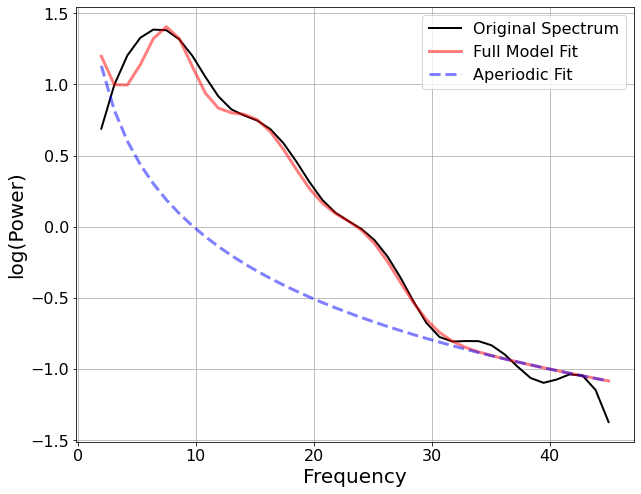

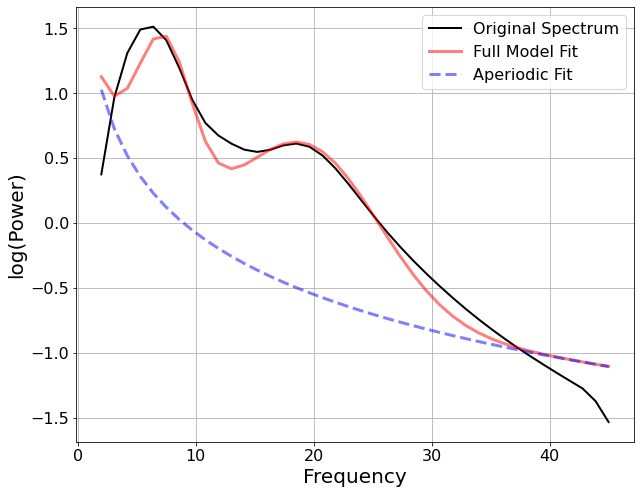

In [175]:
cur_fs1.plot()
cur_fs2.plot()

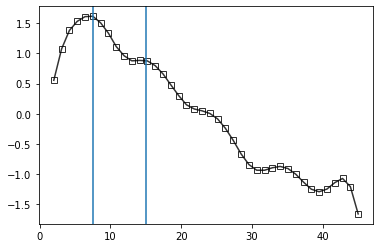

In [149]:
cur_fs = obt_psm_fs(10**meg_psd_curve, FREQS)
plt.plot(FREQS, stdz_vec(meg_psd_curve), linestyle = '-',
         marker = 's',fillstyle = 'none',color = 'k', label = "MEG", alpha = 0.8)
plt.axvline(x=cur_fs[1])
plt.axvline(x=cur_fs[4])